In [1]:
import torch
from torch.utils.data import DataLoader


from data_mgmt import RecSysData as rsd
from data_mgmt.RecSysDataTest import TestRecSysData
from models.ExtremeDeepFactorioMachine import ExtremeDeepFactorizationMachineModel as XFM

# default imports because meh
import numpy as np
import pandas as pd
import seaborn as sns
import os
from copy import deepcopy

In [2]:
# # # # # # # # # # # # # # # #
# INPUTS TO POST PROCESSING!  #
# # # # # # # # # # # # # # # #
ppath   =   os.path.abspath('../data/')
MODEL   =   "moar_pain692"+".pkl"
PATH    =   os.path.join(os.path.abspath('models/saved/'),MODEL)
OUTPATH =   os.path.abspath("../output/")

test_data_file      = os.path.join(ppath,"pairs_Rating.txt")
RESULTS_FILE_NAME   = os.path.join(OUTPATH,"moar_pain692.txt")

In [3]:
def recSysPreprocessing(df_data):
    df_data['uid'], _ = pd.factorize(df_data['reviewerID'])
    df_data['pid'], _ = pd.factorize(df_data['itemID'])
    df_data['cid'], _ = pd.factorize(df_data['categoryID'])

    df_data = df_data[['reviewHash', 'reviewerID',
                        'unixReviewTime', 'itemID','categoryID',
                        'rating', 'uid','pid','cid']]

    return df_data

def recSysXfrm(in_row):
    return torch.tensor([in_row.uid,in_row.pid,in_row.cid],dtype=torch.int)


In [6]:
def beatTheCrapOutOfThisData(dfin, dfout):
    """
    will return a dataframe that has correlated the reviewer and item
    ID's within the test data set versus ones we recognize from the
    training data set.
    """
    dfout.columns = ['reviewerID','itemID']

    uid_pairs = dfin.set_index('reviewerID').loc[
                    dfout.query('reviewerID in @dfin.reviewerID').reviewerID].loc[
                        dfout.query('reviewerID in @dfin.reviewerID').reviewerID].\
                            uid.drop_duplicates().copy()

    pid_cid_pairs = dfin.set_index('itemID').loc[
                    dfout.query('itemID in @dfin.itemID').itemID].loc[
                        dfout.query('itemID in @dfin.itemID').itemID][['pid','cid']].\
                            drop_duplicates(subset=['pid']).copy()

    dfout=dfout.join(uid_pairs,how='left',on='reviewerID')
    dfout=dfout.join(pid_cid_pairs,how='left',on='itemID')

    dfout.uid=dfout.uid.fillna(method='backfill') # kind of a hack for now
    dfout.pid=dfout.pid.fillna(method='backfill')
    dfout.cid=dfout.cid.fillna(method='backfill')

    return dfout

In [7]:
ds_train = rsd.RecSysData(ppath, preprocess=recSysPreprocessing, transform=recSysXfrm)
n_user = ds_train.df_data.copy().uid.unique().shape[0]
n_item = ds_train.df_data.copy().pid.unique().shape[0]
n_cats = ds_train.df_data.copy().cid.unique().shape[0]


ds_test  = TestRecSysData(ds_train.df_data,
                        target_file=test_data_file,
                        correlation_function=beatTheCrapOutOfThisData,
                        transform=ds_train.transform)


tdl = DataLoader(ds_train, batch_size=64, shuffle=False)
tst = DataLoader(ds_test, batch_size=64, shuffle=False)


model_dims = np.array([n_user,n_item,n_cats])


model = XFM(field_dims = model_dims,
            embed_dim = 64,
            mlp_dims  = (32, 32, 32, 32, 32, 32, 32),
            dropout = 0.2,
            cross_layer_sizes = (64, 64),
            split_half=False)



model.load_state_dict(torch.load(PATH))
model.eval()

ExtremeDeepFactorizationMachineModel(
  (embedding): FeaturesEmbedding(
    (embedding): Embedding(59158, 64)
  )
  (cin): CompressedInteractionNetwork(
    (conv_layers): ModuleList(
      (0): Conv1d(9, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(192, 64, kernel_size=(1,), stride=(1,))
    )
    (fc): Linear(in_features=128, out_features=1, bias=True)
  )
  (mlp): MultiLayerPerceptron(
    (mlp): Sequential(
      (0): Linear(in_features=192, out_features=32, bias=True)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=32, out_features=32, bias=True)
      (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.2, inplace=False)
      (8): Linear(in_features=32, out_features=32, bias=True)
      (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [8]:
tst.dataset.df_data

,reviewerID,itemID,uid,pid,cid
0,U566642233,I937291762,17371.0,16702.0,1.0
1,U150556394,I033937358,38819.0,1002.0,0.0
2,U835748092,I634015598,38805.0,16873.0,3.0
3,U636069453,I432257131,2986.0,11220.0,0.0
4,U336431363,I745492929,29830.0,17900.0,0.0
...,...,...,...,...,...
13995,U859380606,I927637487,16453.0,5418.0,3.0
13996,U154721087,I022684654,25479.0,2019.0,3.0
13997,U603183833,I813224083,6322.0,1502.0,3.0
13998,U901473480,I085879999,30043.0,18945.0,0.0


In [ ]:
model

In [9]:
def test_loop(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss = torch.zeros(1)
    predictions = torch.Tensor([])

    with torch.no_grad():
        for X in dataloader:
            pred = model(X.type(torch.long)).flatten()
            predictions = torch.cat((predictions,pred),axis=-1)

    return predictions

In [10]:
PREDICTIT = test_loop(tst, model)
outoutout=ds_test.df_data.copy()
outoutout['rating']=PREDICTIT.numpy()
ininin = ds_train.df_data.copy()

outoutout.loc[outoutout.rating < 1.0,'rating'] = 1.0
outoutout.loc[outoutout.rating > 5.0,'rating'] = 5.0

ininin['set']='train'
outoutout['set']='test'
full=ininin.append(outoutout)

/tmp/ipykernel_619009/238859286.py:13: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor([in_row.uid,in_row.pid,in_row.cid],dtype=torch.int)


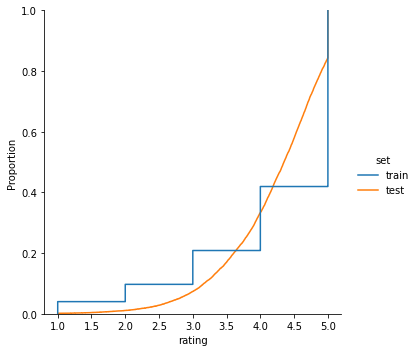

In [11]:
sns.displot(data=full.reset_index(),x='rating',kind='ecdf',hue='set')

In [ ]:
with open(RESULTS_FILE_NAME,'w') as filee:
    filee.write("reviewerID-itemID,prediction\n")
    for i in range(len(outoutout)):
        filee.write(f"{outoutout.reviewerID.iloc[i]}-{outoutout.itemID.iloc[i]},{outoutout.rating.iloc[i]}\n")